In [46]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

# 获取读取数据

In [47]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
all_data = pd.read_csv('./housing.csv', header=None, delimiter=r"\s+", names=column_names)

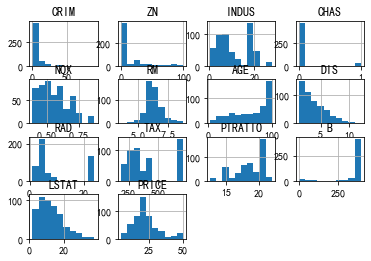

In [48]:
all_data.hist()
plt.show()

In [49]:
all_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


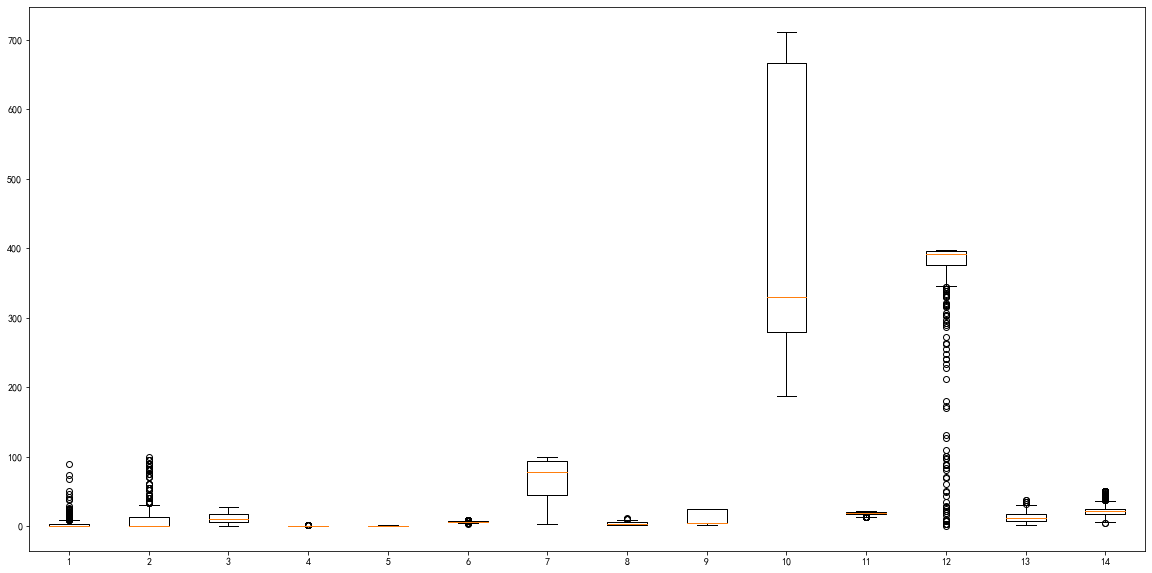

In [50]:
plt.figure(figsize=(20,10))
plt.boxplot(all_data)
plt.show()

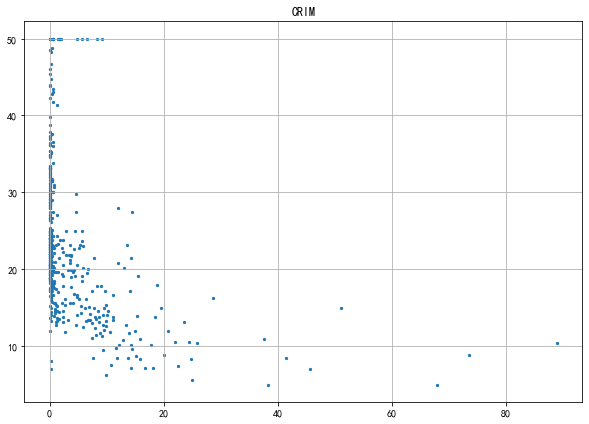

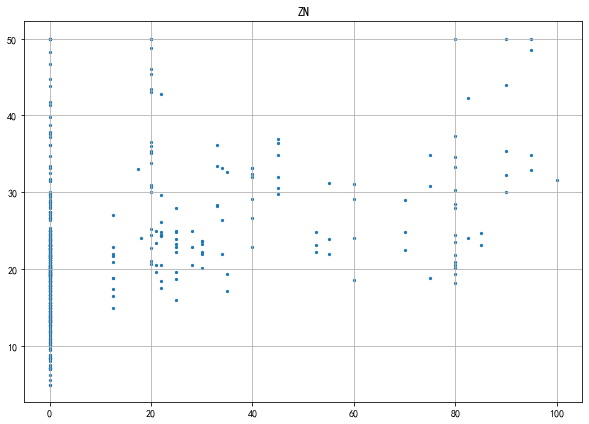

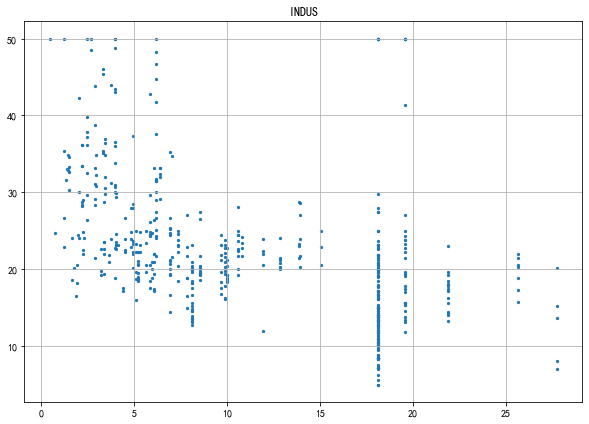

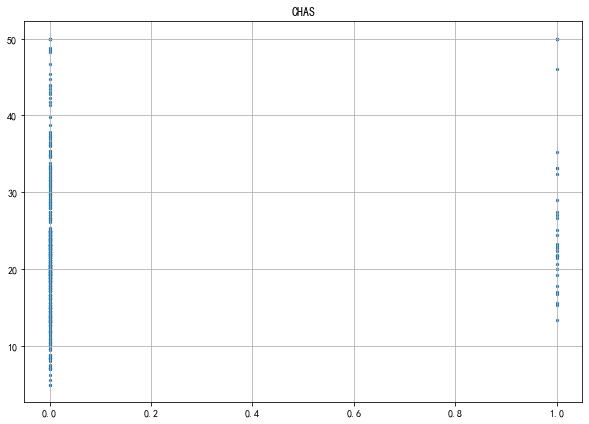

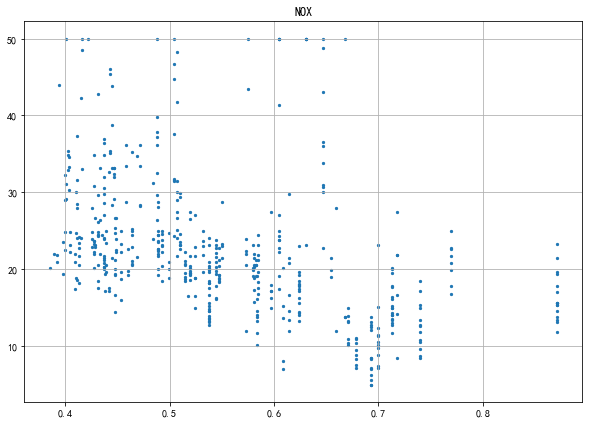

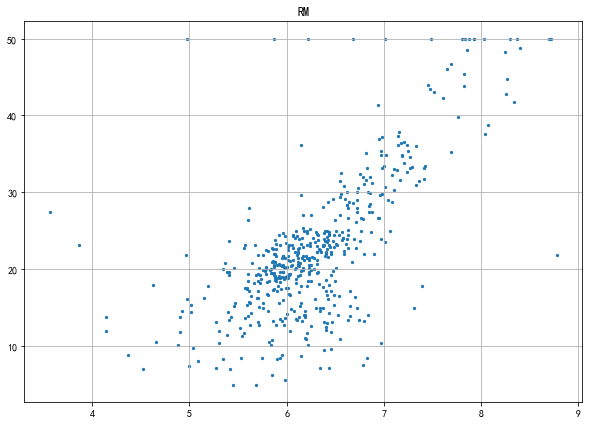

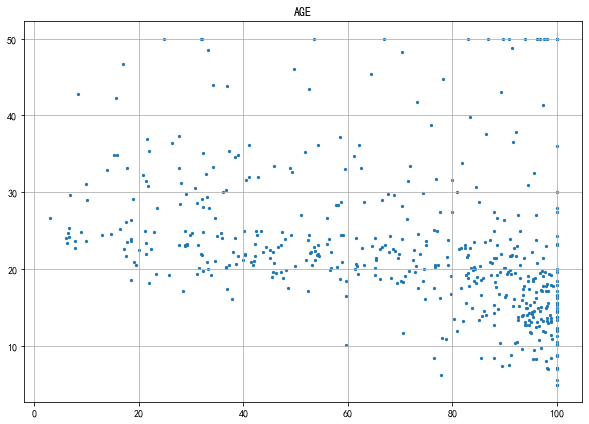

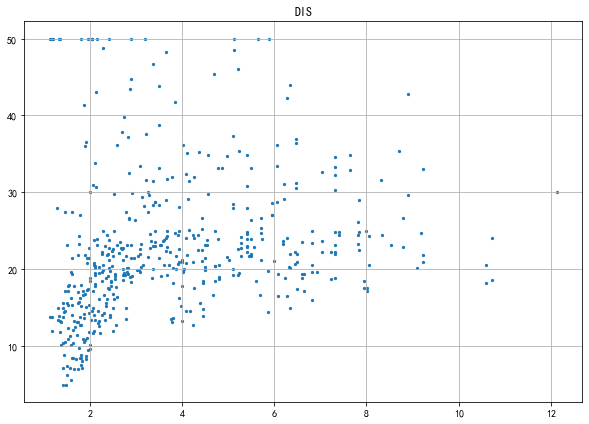

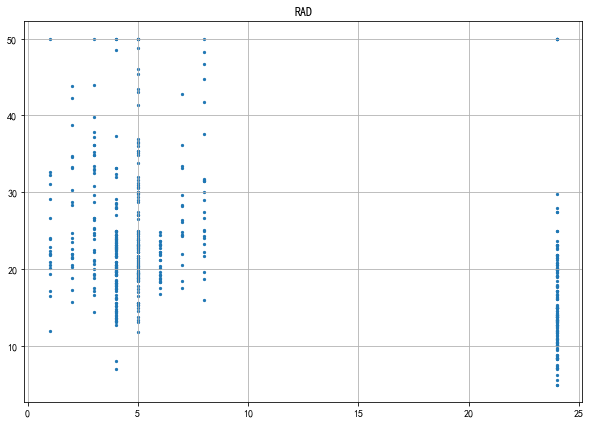

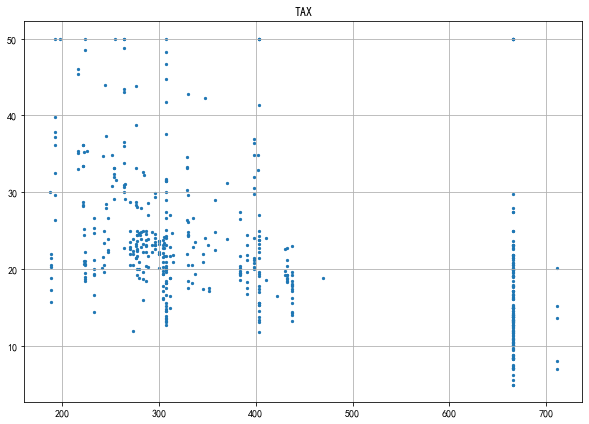

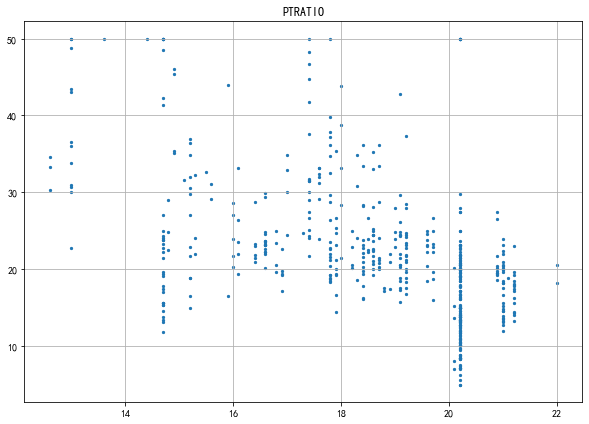

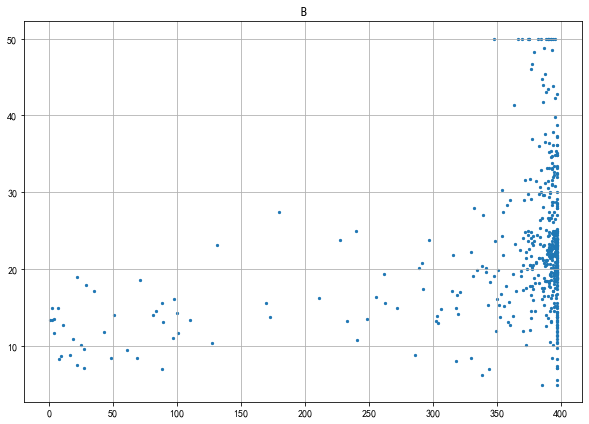

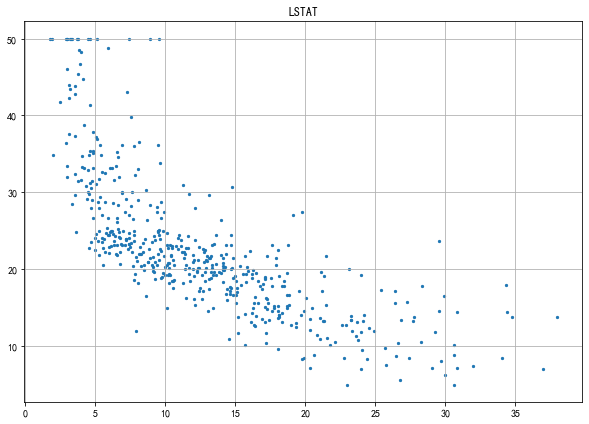

In [51]:
data=all_data.iloc[:,:-1]
label=all_data.iloc[:,-1]

data=np.array(data,dtype=float)
label=np.array(label,dtype=float)

for i in range(13):
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.scatter(data[:, i], label, s=5)  # 横纵坐标和点的大小
    plt.title(column_names[i])
plt.show()

In [52]:
unsF = []  # 次要特征下标
for i in range(data.shape[1]):
    if column_names[i] == 'CHAS':
        unsF.append(i)
data = np.delete(data, unsF, axis=1)  # 删除次要特征

In [53]:
unsT = []  # 房价异常值下标
for i in range(data.shape[1]):
    if label[i] > 46:
        unsT.append(i)
data = np.delete(data, unsT, axis=0)  # 删除样本异常值数据
label = np.delete(label, unsT, axis=0)  # 删除异常房价


In [54]:

data=torch.tensor(data,dtype=torch.float)
label=torch.tensor(label,dtype=torch.float)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data,label, test_size = 0.3, random_state = 4)

<AxesSubplot:>

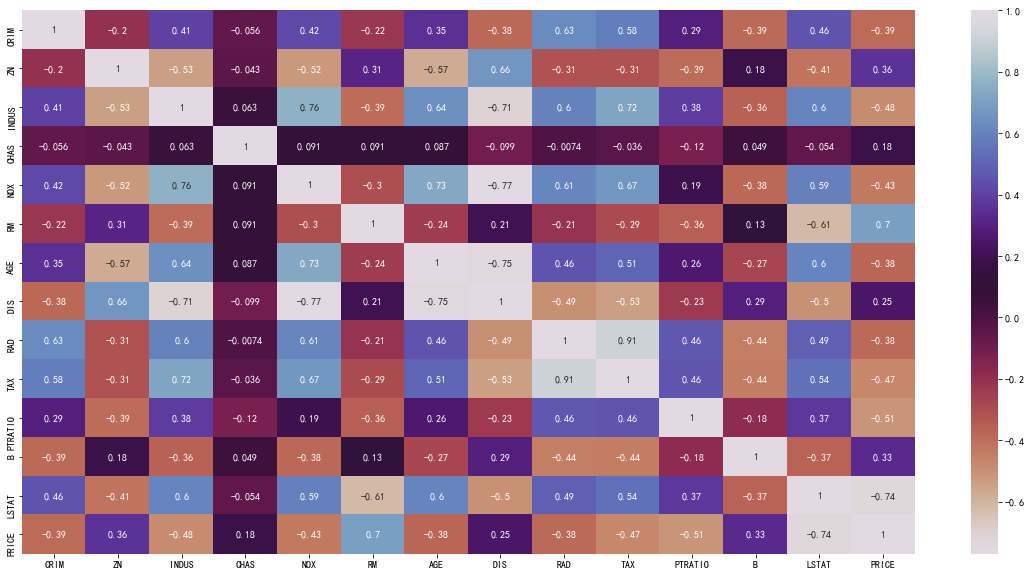

In [56]:
corr = all_data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr,  annot=True, cmap='twilight_r')

In [57]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    loss = 0.0
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view_as(output))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()/len(train_loader)))

In [58]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += criterion(output, target.view_as(output)).item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}\n'.format(
        test_loss))
    return test_loss

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [60]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Net().to(device)
optimizer=torch.optim.Adam(params=model.parameters())
criterion=nn.MSELoss()

In [61]:
trainset=TensorDataset(X_train,y_train)
trainloader=DataLoader(trainset,batch_size=64,shuffle=True, num_workers=0)
testset=TensorDataset(X_test,y_test)
testloader=DataLoader(testset,batch_size=64,shuffle=False, num_workers=0)

In [62]:
epoch_list, loss_list = [], []

for epoch in range(1, 1000):
    train(model, device, trainloader, optimizer, epoch, criterion)
    test_loss=test(model, device, testloader, criterion)
    epoch_list.append(epoch)
    loss_list.append(test_loss)

Train Epoch: 1 Loss: 147.128703
Test set: Average loss: 8.6818

Train Epoch: 2 Loss: 72.087748
Test set: Average loss: 3.1786

Train Epoch: 3 Loss: 20.930407
Test set: Average loss: 2.9365

Train Epoch: 4 Loss: 22.018349
Test set: Average loss: 2.1884

Train Epoch: 5 Loss: 15.148790
Test set: Average loss: 2.0271

Train Epoch: 6 Loss: 11.256777
Test set: Average loss: 2.0522

Train Epoch: 7 Loss: 11.368081
Test set: Average loss: 1.7843

Train Epoch: 8 Loss: 11.014102
Test set: Average loss: 1.7240

Train Epoch: 9 Loss: 9.951698
Test set: Average loss: 1.8035

Train Epoch: 10 Loss: 7.286873
Test set: Average loss: 1.7265

Train Epoch: 11 Loss: 11.134135
Test set: Average loss: 1.6955

Train Epoch: 12 Loss: 6.047068
Test set: Average loss: 1.6474

Train Epoch: 13 Loss: 9.742818
Test set: Average loss: 1.6267

Train Epoch: 14 Loss: 7.027699
Test set: Average loss: 1.6312

Train Epoch: 15 Loss: 5.976731
Test set: Average loss: 1.5928

Train Epoch: 16 Loss: 11.357677
Test set: Average loss

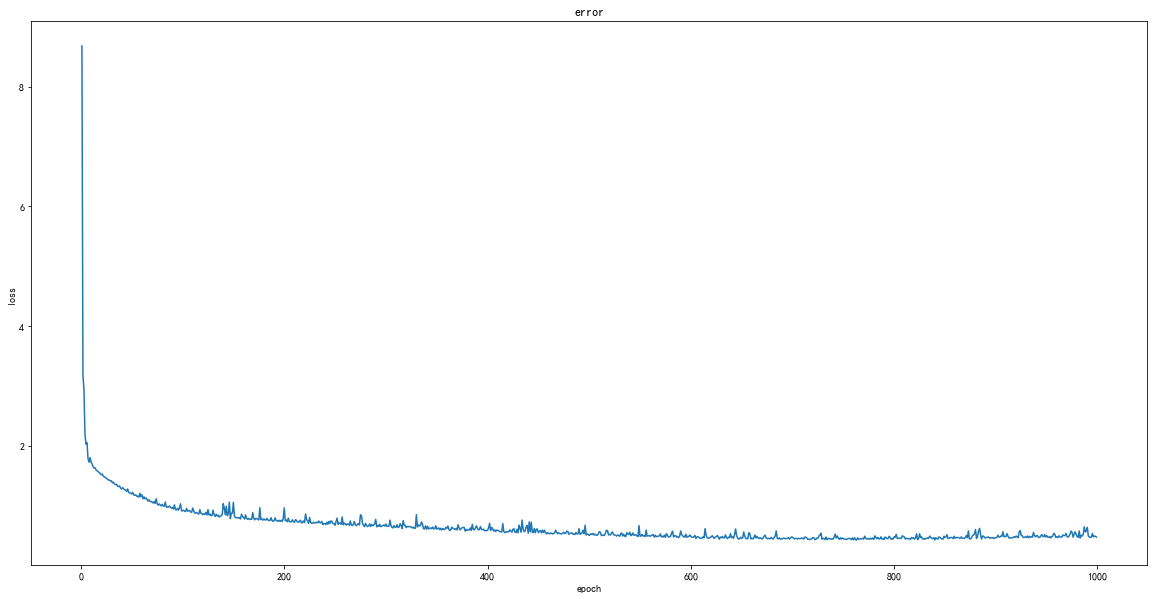

In [63]:
fig = plt.figure(figsize=(20, 10))
plt.plot(epoch_list, loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('error')
plt.show()

In [64]:
def read(test_loader):
    model.eval()
    output_list,target_list=[],[]
    with torch.no_grad():
        for data, target in test_loader:
            model.to('cpu')
            output = model(data).detach().cpu().numpy()
            output_list.extend(output)
            target_list.extend(target.cpu().numpy())
    p=pd.DataFrame(output_list, columns=['predict'])
    p['real']=target_list
    print(p.head())
    return p
            
            

In [65]:
p=read(testloader)

# 与验证值作比较
error1 = mean_squared_error(p.iloc[:,1], p.iloc[:,0]).round(5)  # 平方差
score1 = r2_score(p.iloc[:,1], p.iloc[:,0]).round(5)  # 相关系数




     predict       real
0  15.045938  16.500000
1  21.321939  24.799999
2  19.757936  17.400000
3  15.816388  19.299999
4  42.103115  37.599998


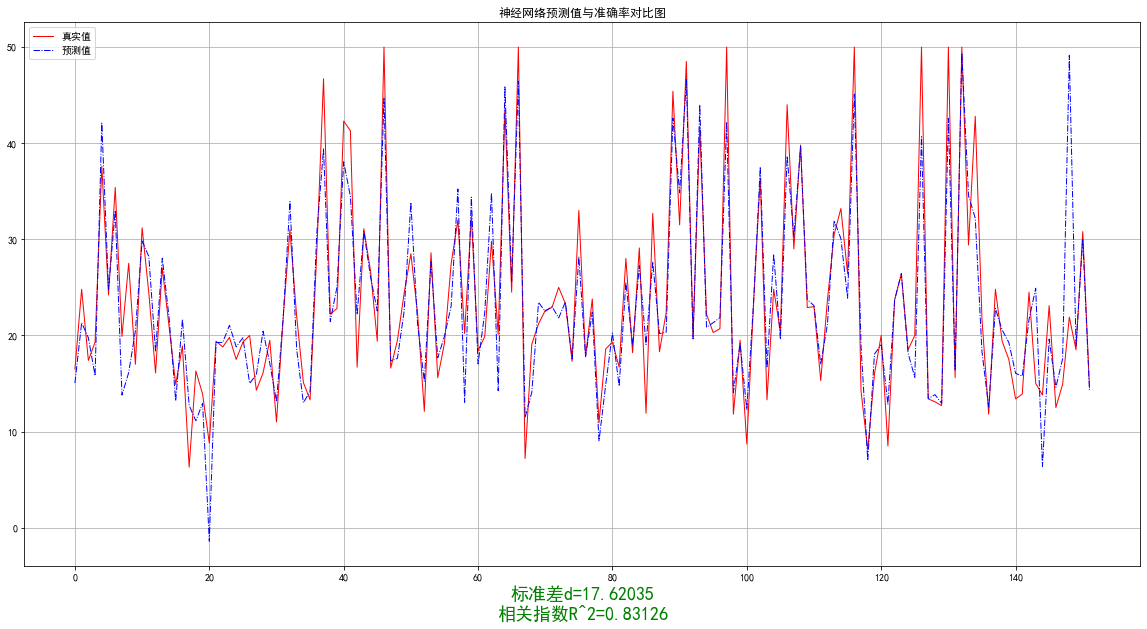

In [66]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "SimHei"
plt.rcParams['axes.unicode_minus'] = False
fig1 = plt.figure(figsize=(20, 10))
plt.plot(range(p.shape[0]), p.iloc[:,1], color='red', linewidth=1, linestyle='-')
plt.plot(range(p.shape[0]), p.iloc[:,0], color='blue', linewidth=1, linestyle='dashdot')
plt.legend(['真实值', '预测值'])
plt.title('神经网络预测值与准确率对比图')
error1 = "标准差d=" + str(error1)+"\n"+"相关指数R^2="+str(score1)
plt.xlabel(error1, size=18, color="green")
plt.grid()
plt.show()

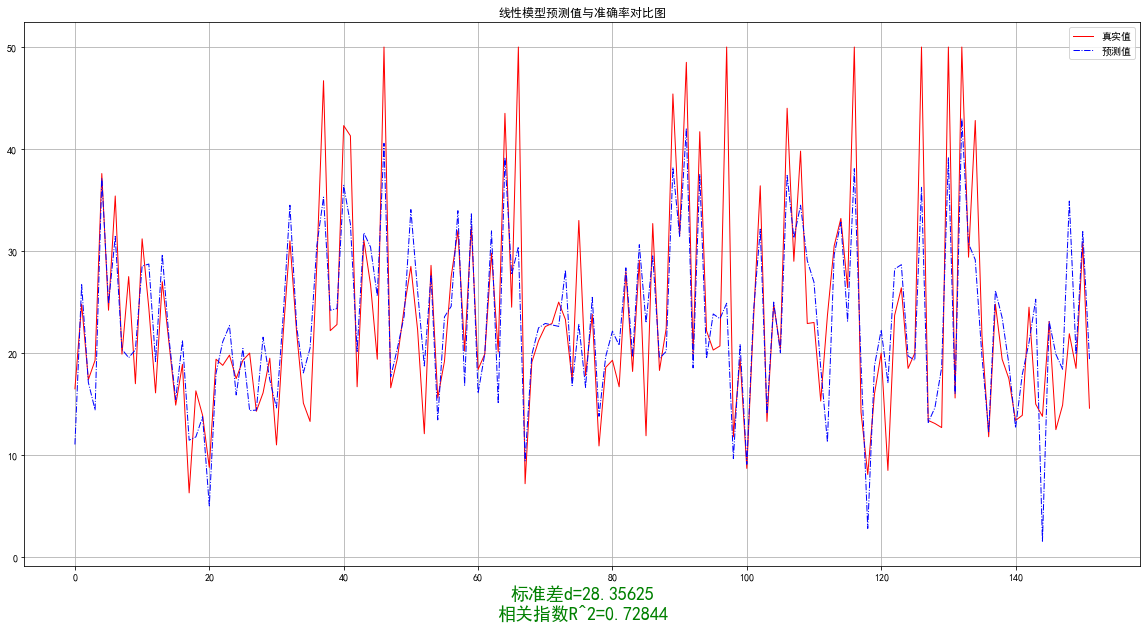

In [67]:
lf = LinearRegression()
lf.fit(X_train, y_train)  # 训练数据,学习模型参数
y_predict = lf.predict(X_test)

error2 = mean_squared_error(y_test.numpy(), y_predict).round(5)  # 平方差
score2 = r2_score(y_test, y_predict).round(5)



fig2 = plt.figure(figsize=(20, 10))
plt.plot(range(y_test.shape[0]), y_test, color='red', linewidth=1, linestyle='-')
plt.plot(range(y_test.shape[0]), y_predict, color='blue', linewidth=1, linestyle='dashdot')
plt.legend(['真实值', '预测值'])
plt.title('线性模型预测值与准确率对比图')
error2 = "标准差d=" + str(error2)+"\n"+"相关指数R^2="+str(score2)
plt.xlabel(error2, size=18, color="green")
plt.grid()
plt.show()
